In [220]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np
from sklearn import preprocessing
import pickle
from sklearn.model_selection import StratifiedShuffleSplit

In [221]:
with open('song_df_aggregate.pkl', 'rb') as f:
        song_df= pickle.load(f)  

In [222]:
to_pop =["artist","title","isnew","rank","date","spotify_id","spotify_album_id","spotify_album_release_date",
         "spotify_album_release_date_precision","album_label","join","spotify_album_release_date_datetime",
         "datetime","first_date"]
[song_df.pop(i) for i in to_pop]


[0                       Lewis Capaldi
 1                         Post Malone
 2       Shawn Mendes & Camila Cabello
 3                               Lizzo
 4                        Selena Gomez
                     ...              
 8514                      Spice Girls
 8515                           Phajja
 8516               Sting & The Police
 8517                     Shania Twain
 8518                    Reba McEntire
 Name: artist, Length: 8519, dtype: object,
 0                           Someone You Loved
 1                                     Circles
 2                                    Senorita
 3                                 Truth Hurts
 4                         Lose You To Love Me
                         ...                  
 8514                       Spice Up Your Life
 8515               So Long (Well, Well, Well)
 8516           Roxanne `97 - Puff Daddy Remix
 8517    Don't Be Stupid (You Know I Love You)
 8518                                  What If
 Name: tit

In [223]:
song_df.pop("bestrank")
song_df.pop("numberofappearances")
song_df = song_df.dropna()
top10 = song_df.pop("top10")


In [224]:
to_pop =["top50","top25","top75","top5"]
[song_df.pop(i) for i in to_pop]

[1        True
 2        True
 4        True
 6        True
 7        True
         ...  
 8507     True
 8510    False
 8512    False
 8516    False
 8517    False
 Name: top50, Length: 6026, dtype: bool, 1        True
 2        True
 4        True
 6        True
 7        True
         ...  
 8507    False
 8510    False
 8512    False
 8516    False
 8517    False
 Name: top25, Length: 6026, dtype: bool, 1        True
 2        True
 4        True
 6        True
 7        True
         ...  
 8507     True
 8510    False
 8512     True
 8516    False
 8517    False
 Name: top75, Length: 6026, dtype: bool, 1        True
 2        True
 4        True
 6       False
 7       False
         ...  
 8507    False
 8510    False
 8512    False
 8516    False
 8517    False
 Name: top5, Length: 6026, dtype: bool]

In [225]:
to_pop =["label_appearance_count","label_category","label_appearance_count_group","release_month","release_year"]
[song_df.pop(i) for i in to_pop]


[1       107.0
 2        76.0
 4        70.0
 6       108.0
 7       596.0
         ...  
 8507      8.0
 8510     37.0
 8512     14.0
 8516      2.0
 8517     73.0
 Name: label_appearance_count, Length: 6026, dtype: float64,
 1        Great Label
 2          Big Label
 4          Big Label
 6        Great Label
 7         Mega Label
             ...     
 8507      Mini Label
 8510    Decent Label
 8512     Small Label
 8516      Mini Label
 8517       Big Label
 Name: label_category, Length: 6026, dtype: object,
 1       161.0
 2        92.0
 4       297.0
 6       118.0
 7       599.0
         ...  
 8507    112.0
 8510     37.0
 8512     15.0
 8516     58.0
 8517     73.0
 Name: label_appearance_count_group, Length: 6026, dtype: float64,
 1        9.0
 2        6.0
 4       10.0
 6        6.0
 7        6.0
         ... 
 8507     1.0
 8510     9.0
 8512     3.0
 8516    11.0
 8517    11.0
 Name: release_month, Length: 6026, dtype: float64,
 1       2019.0
 2       2019.0
 4       2

In [226]:
to_pop =["artist_has_award","spotify_disc_number","last_award_type","spotify_mode","num_artists","spotify_time_signature","album_type","spotify_explicit"]
[song_df.pop(i) for i in to_pop]


[1       True
 2       True
 4       True
 6       True
 7       True
         ... 
 8507    True
 8510    True
 8512    True
 8516    True
 8517    True
 Name: artist_has_award, Length: 6026, dtype: bool, 1       1.0
 2       1.0
 4       1.0
 6       1.0
 7       1.0
        ... 
 8507    1.0
 8510    1.0
 8512    2.0
 8516    1.0
 8517    1.0
 Name: spotify_disc_number, Length: 6026, dtype: float64, 1       Platinum
 2       Platinum
 4       Platinum
 6       Platinum
 7       Platinum
           ...   
 8507        Gold
 8510    Platinum
 8512    Platinum
 8516    Platinum
 8517        Gold
 Name: last_award_type, Length: 6026, dtype: object, 1       1.0
 2       0.0
 4       1.0
 6       0.0
 7       0.0
        ... 
 8507    1.0
 8510    1.0
 8512    1.0
 8516    1.0
 8517    1.0
 Name: spotify_mode, Length: 6026, dtype: float64, 1       1.0
 2       2.0
 4       1.0
 6       2.0
 7       1.0
        ... 
 8507    1.0
 8510    1.0
 8512    1.0
 8516    1.0
 8517    1.0
 Name: nu

In [235]:
song_df = song_df[song_df["firstrank"] > 10]

In [236]:
le = preprocessing.LabelEncoder()
#song_df['spotify_explicit'] = le.fit_transform(song_df['spotify_explicit'])
song_df['spotify_key'] = le.fit_transform(song_df['spotify_key'])
#song_df['spotify_mode'] = le.fit_transform(song_df['spotify_mode'])
#song_df['last_award_type'] = le.fit_transform(song_df['last_award_type'])
song_df['label_category_group'] = le.fit_transform(song_df['label_category_group'])
#song_df['album_type'] = le.fit_transform(song_df['album_type'])
song_df['datetime_year'] = le.fit_transform(song_df['datetime_year'])
song_df['datetime_month'] = le.fit_transform(song_df['datetime_month'])

/Users/iliasmiraoui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/iliasmiraoui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/iliasmiraoui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [237]:
X_train, X_test, y_train, y_test = train_test_split(song_df, top10, test_size=0.3)

ValueError: Found input variables with inconsistent numbers of samples: [5828, 6026]

In [254]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
#lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)


#can replace 'is_unbalance': 'true', by 'scale_pos_weight': 10,

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
    'is_unbalance': 'true',
    'num_leaves': 25,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lgb.train(parameters,
                       lgb_train,
                       valid_sets=lgb_train,
                       num_boost_round=100,
                       early_stopping_rounds=100)

predictions = model.predict(X_test)


[1]	training's auc: 0.647702
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.708717
[3]	training's auc: 0.79937
[4]	training's auc: 0.803496
[5]	training's auc: 0.806092
[6]	training's auc: 0.804919
[7]	training's auc: 0.807055
[8]	training's auc: 0.809757
[9]	training's auc: 0.829264
[10]	training's auc: 0.830278
[11]	training's auc: 0.843755
[12]	training's auc: 0.845357
[13]	training's auc: 0.851071
[14]	training's auc: 0.859908
[15]	training's auc: 0.862048
[16]	training's auc: 0.868791
[17]	training's auc: 0.872118
[18]	training's auc: 0.875665
[19]	training's auc: 0.875825
[20]	training's auc: 0.875107
[21]	training's auc: 0.877797
[22]	training's auc: 0.882392
[23]	training's auc: 0.887235
[24]	training's auc: 0.889362
[25]	training's auc: 0.891929
[26]	training's auc: 0.893624
[27]	training's auc: 0.896782
[28]	training's auc: 0.899038
[29]	training's auc: 0.901616
[30]	training's auc: 0.902158
[31]	training's auc: 0.904016
[32]	training's au

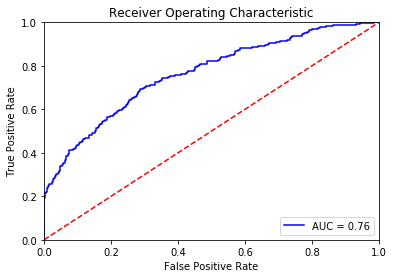

In [239]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

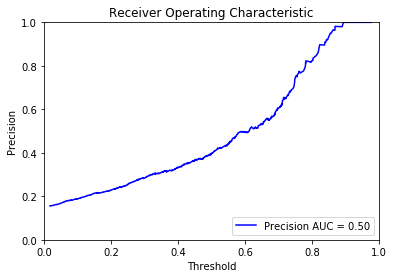

In [255]:
from sklearn.metrics import precision_recall_curve
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test,predictions)
# calculate precision-recall AUC
precision_auc = metrics.auc(recall, precision)

plt.title('Receiver Operating Characteristic')
plt.plot(thresholds, precision[:len(precision)-1], 'b', label = 'Precision AUC = %0.2f' % precision_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Threshold')
plt.show()

In [263]:
from sklearn.metrics import confusion_matrix

predictions_matrix = [1 if pred > 0.90 else 0 for pred in predictions]
confusion_matrix(y_test,predictions_matrix)

array([[1529,    0],
       [ 230,   49]])

In [240]:
# Record the feature importances
feature_importances = model.feature_importance()
for i in range(len(feature_importances)):
    print(feature_importances[i],X_train.columns[i])

169 spotify_duration_ms
79 spotify_track_number
80 spotify_key
159 spotify_danceability
148 spotify_energy
144 spotify_loudness
145 spotify_speechiness
175 spotify_acousticness
77 spotify_instrumentalness
154 spotify_liveness
160 spotify_valence
175 spotify_tempo
103 award_num
77 gold_count
108 platinum_count
59 num_songs_awards
181 firstrank
38 label_category_group
103 datetime_year
66 datetime_month


In [241]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/iliasmiraoui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [242]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.86


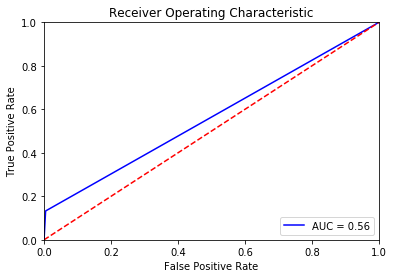

In [246]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [248]:
230/1578

0.14575411913814956